In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp
import seaborn as sns

In [30]:
fig_width_pt = 455.24411 / 3 # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0 / 72.27  # Convert pt to inches
golden_mean = (np.sqrt(5) - 1.0) / 2.0  # Aesthetic ratio
fig_width = fig_width_pt * inches_per_pt  # width in inches
fig_height = fig_width * golden_mean  # height in inches
fig_size = [fig_width, fig_height]
params = {'axes.labelsize': 8,
          'font.sans-serif': 'Arial',
          'font.size': 8,
          'legend.fontsize': 8,
          'xtick.labelsize': 8,
          'ytick.labelsize': 8,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)

In [10]:
import string
from itertools import cycle


def label_axes(fig, labels=None, loc=None, **kwargs):
    """
    Walks through axes and labels each.
    kwargs are collected and passed to `annotate`
    Parameters
    ----------
    fig : Figure
         Figure object to work on
    labels : iterable or None
        iterable of strings to use to label the axes.
        If None, lower case letters are used.
    loc : len=2 tuple of floats
        Where to put the label in axes-fraction units
    """
    if labels is None:
        labels = string.ascii_lowercase

    # re-use labels rather than stop labeling
    labels = cycle(labels)
    if loc is None:
        loc = (-0.05, 1.05)
    for ax, lab in zip(fig.axes, labels):
        ax.annotate(lab, xy=loc, ha='right', weight='bold', size=8,
                    xycoords='axes fraction',
                    **kwargs)

In [4]:
def simple_addcyto(t, y, deathrates, repairrate, ctldamagerate, proliferationrate, ctlchemokillrate, chemodamagerate, 
                   ctlrecruitment, ctlremoval, ctlchemots, tumorchemots):
    imax = len(deathrates)
    ti = y[:imax]
    ctl, chemo = y[imax:]
    dti = np.zeros_like(ti)
    dti[:-1] += repairrate * ti[1:]  # repair
    dti[1:] -= repairrate * ti[1:]
    dti -= deathrates * ti  # tumor cell death

    dti[0] += proliferationrate * ti[0]  # tumor cell proliferation

    dti[1:] += (ctldamagerate * ctl + chemodamagerate * chemo / (tumorchemots + chemo)) * ti[:-1]  # tumor cell damage
    dti[:-1] -= (ctldamagerate * ctl + chemodamagerate * chemo / (tumorchemots + chemo)) * ti[:-1]
    dctl = ctlrecruitment - ctlremoval * ctl - ctlchemokillrate * chemo * ctl / (ctlchemots + chemo)  # ctl kill by chemo, recruitment, removal
    dchemo = 0.
    return [*dti, dctl, dchemo]
    

In [5]:
deathrates = np.array((0., 0.1, 0.5))
repairrate = 6
ctldamagerate = 1
proliferationrate =  1. / 24
ctlchemokillrate = .05
chemodamagerate = 1
ctlrecruitment = 0.01
ctlremoval = 0.01
ctlchemots = 10
tumorchemots = 0.1

ctl0 = 1.
chemo0 = 0

y0 = np.array([1., 0, 0, ctl0, chemo0])
tmax = 96
ts = np.linspace(0, tmax, 101)

In [270]:
sol = solve_ivp(simple_addcyto, (0, tmax), y0, t_eval=ts, args=(deathrates, repairrate, ctldamagerate, proliferationrate, ctlchemokillrate, chemodamagerate, 
                   ctlrecruitment, ctlremoval, ctlchemots, tumorchemots))

In [271]:
# simple_addcyto(0, y0, deathrates, repairrate, ctldamagerate, proliferationrate, ctlchemokillrate, chemodamagerate, 
#                    ctlrecruitment, ctlremoval, ctlchemots, tumorchemots)

In [6]:
imax = len(deathrates)


<Figure size 629.921x389.313 with 0 Axes>

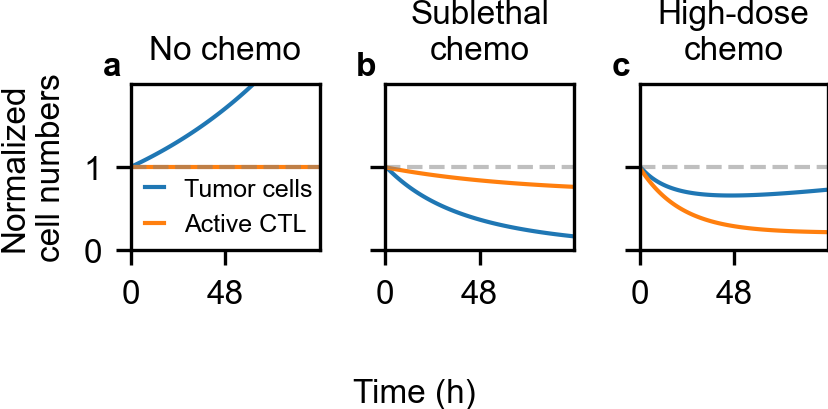

In [45]:
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(3, 1.5))

c0s = [0, 1, 30]
for c, ax in zip(c0s, axs):
    y0 = np.array([1., 0, 0, ctl0, c])
    sol = solve_ivp(simple_addcyto, (0, tmax), y0, t_eval=ts, args=(deathrates, repairrate, ctldamagerate, proliferationrate, ctlchemokillrate, chemodamagerate, 
                   ctlrecruitment, ctlremoval, ctlchemots, tumorchemots))
    
    T = sol.y[:imax].sum(0)
    ctl = sol.y[imax]
    chemo = sol.y[-1]
    t = sol.t
    ax.plot(t, T, label='Tumor cells', lw=1)
    ax.plot(t, ctl, label='Active CTL', lw=1)
    ax.plot([t[0], t[-1]], [1, 1], '--', c='gray', alpha=.5, lw=1)
#     plt.legend()
#     plt.xlabel('Time (h)')
#     plt.ylabel('Normalized numbers')
#     plt.title('No chemotherapy ($C=0$)')
    plt.ylim(0, 2)
    plt.xlim(0, 96)
    plt.xticks([0, 48])

# plt.yscale('log')
# plt.savefig('nochemo.svg')
axs[0].legend(borderpad=0.05, fontsize=6, frameon=False, handlelength=.75, edgecolor='1.')
axs[0].set_ylabel('Normalized\ncell numbers')
axs[0].set_yticks([0, 1])
axs[0].set_title('No chemo', size=8)
axs[1].set_title('Sublethal\nchemo', size=8)
axs[2].set_title('High-dose\nchemo', size=8)
label_axes(fig)
fig.supxlabel('Time (h)', size=8)
plt.tight_layout()
plt.savefig('treatment.svg')
plt.show()